# GPAO I
This is basic structure of code itself using toy model. Throughout the M\"uller Brown example, we are going to learn

1. Projector
2. Database
3. Gaussian Potential

## Pathway optimization on the projected space.

Previouse MB example was conducted on the direct space. We can perform this in the reduced space using `Projector` class. Sine projector performs descrete sine transformation of the components and perform the pathway optimization. For example, 


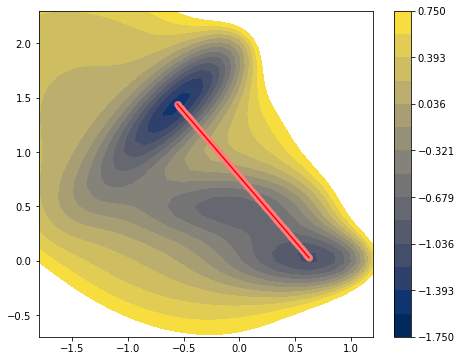

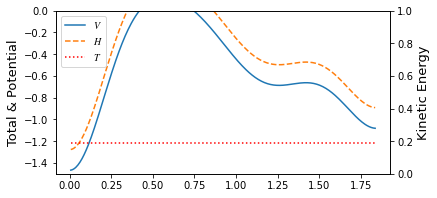

In [1]:
import numpy as np
from taps.paths import Paths
from taps.model import MullerBrown
from taps.coords import Coords
from taps.visualize import view

N = 300

x = np.linspace(-0.55822365, 0.6234994, N)
y = np.linspace(1.44172582, 0.02803776, N)

coords = Coords(coords=np.array([x, y]))
model = MullerBrown()
paths = Paths(coords=coords, model=model)
view(paths, viewer='MullerBrown')

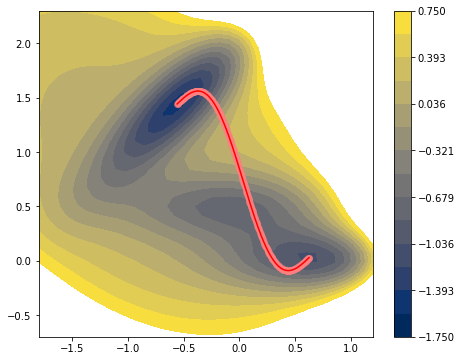

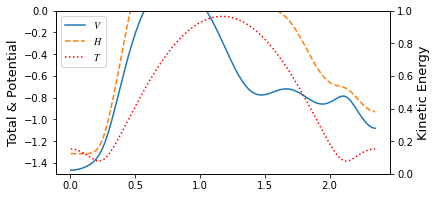

In [2]:
from taps.projectors import Sine

Nk = N - 210
prj = Sine(N=N, Nk=Nk, init=paths.coords[:, 0].copy(), fin=paths.coords[:, -1].copy())
sine_coords = prj.x(paths.coords(index=np.s_[..., 1:-1]))

sine_coords[1, 1] = 5
new_coords = prj.x_inv(sine_coords)
paths.coords.coords[..., 1:-1] = new_coords.coords
view(paths, viewer='MullerBrown')

In [3]:
from taps.pathfinder import DAO

search_kwargs = {"method":"L-BFGS-B",
                  "options": {'disp': None,
                              'maxcor': 20,
                              'ftol': 2.220446049250313e-4,
                              'gtol': 1e-03,
                              'eps': 5e-6, 
                              'maxfun': 1000,
                              'maxiter': 1000,
                              'iprint': -1, 'maxls': 100,
                              'finite_diff_rel_step': 1e-6}}


finder = DAO(Et=-0.45, muE=1., tol=1e-2, gam=1.,
             action_name = ['Onsager Machlup', "Energy conservation"],
             prj_search=True, sin_search=False,
             search_kwargs=search_kwargs, 
             prj=prj)



paths.finder = finder
paths.coords.epoch=6
paths.search()


Action name  : Onsager Machlup + Energy conservation
Target energy: -0.45
Target type  : manual
muE          : 1.0
gamma        : 1.0
            Iter   nfev   njev        S   dS_max
converg :    345    358    358   2.9363   0.6397
converg :    347    363    363   2.9345   0.1822
jac_max > tol(0.01); Run without gradient
converg :    348    367    367   2.9341   0.3690


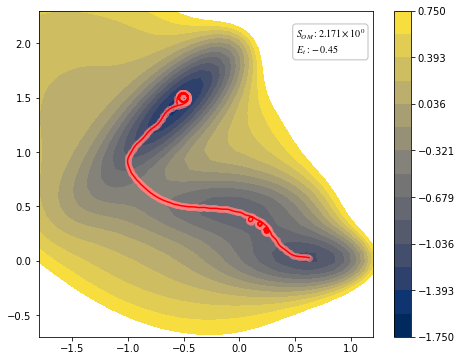

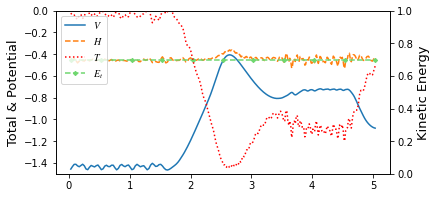

In [4]:
view(paths, viewer="MullerBrown")

## Iteration reduced from 1100 to

Only used the 30% of the components. 

## Database construction

In [5]:
from taps.db.data import ImageData
imgdata = ImageData("mullerbrown.db")

In [6]:
imgdata.add_data(paths, coords=paths.coords[..., [0, -1]])

{'image': [1, 2]}

In [7]:
imgdata.read_all()["image"][0], imgdata.read_all()["image"][1]

((array([-0.55822365,  1.44172582]),
  None,
  'Finished',
  1629603563.4727376,
  -1.4669951720995384,
  None,
  array([ 5.43788282e-08, -2.06867418e-07]),
  1629603563.4754255,
  None,
  None),
 (array([0.6234994 , 0.02803776]),
  None,
  'Finished',
  1629603563.475453,
  -1.0816672411685238,
  None,
  array([-2.50191479e-08,  3.64354996e-08]),
  1629603563.477985,
  None,
  None))

## Gaussian Potential

In [8]:
from taps.ml.gaussian import Gaussian
hyperparameters = {'sigma_f': 1, 'sigma_n^f': 1e-8, 'sigma_n^e':1e-6,
                   'l^2': 0.1}
hyperparameters_bounds = {'sigma_f': (1, 1), 'sigma_n^f': (1e-8, 1e-6), 'sigma_n^e':(1e-6, 1e-4), 'l^2': (1e-4, 4)}

paths.imgdata = imgdata
model = Gaussian(real_model=model,
                 hyperparameters=hyperparameters,
                 hyperparameters_bounds=hyperparameters_bounds)
paths.model = model
paths.add_data(index=[0, -1])

{'image': [1, 2]}

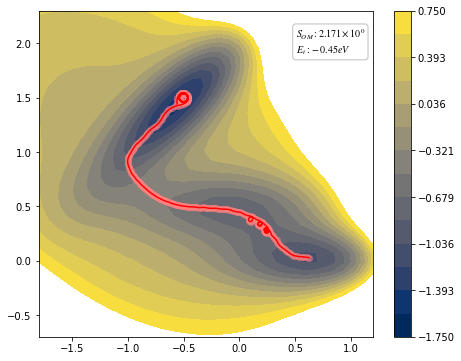

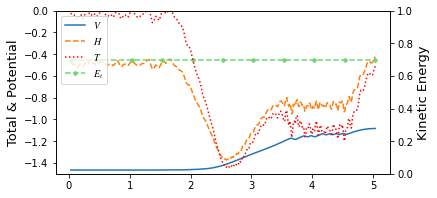

In [9]:
view(paths, viewer="MullerBrown", gaussian=True)

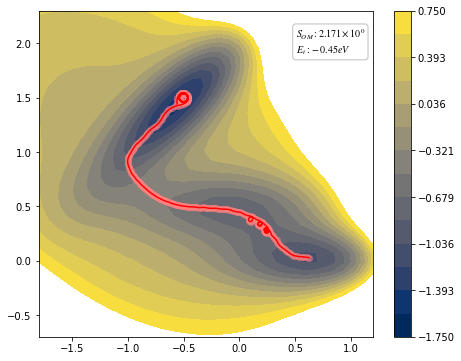

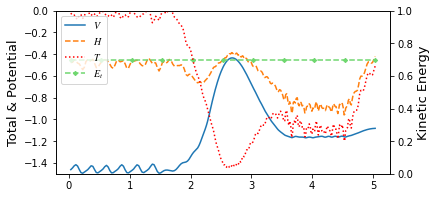

In [12]:
paths.add_data(index=[50, 150])
view(paths, viewer="MullerBrown")

## Pathway optimization perfomed

We will going to use direct action optimization. There is some trivial case around it. 

In [39]:
from taps.pathfinder import DAO

search_kwargs = {"method":"L-BFGS-B",
                  "options": {'disp': None,
                              'maxcor': 20,
                              'ftol': 2.220446049250313e-4,
                              'gtol': 1e-03,
                              'eps': 5e-6, 
                              'maxfun': 1000,
                              'maxiter': 1000,
                              'iprint': -1, 'maxls': 100,
                              'finite_diff_rel_step': 1e-6}}

#prj = Sine(N=N, Nk=N-2, init=paths.coords[..., 0].copy(), fin=paths.coords[..., -1].copy())

finder = DAO(Et=-0.45, muE=1., tol=5e-2, gam=1.,
             action_name = ['Onsager Machlup', "Energy conservation"],
           #  prj_search=True, sin_search=False,
             search_kwargs=search_kwargs)


#finder = GPAO(real_finder=finder, label= directory + "gpao_1/1", phases=["auto et"])
paths.finder = finder
paths.coords.epoch=6
paths.search()

Action name  : Onsager Machlup + Energy conservation
Target energy: -0.45
Target type  : manual
muE          : 1.0
gamma        : 1.0
            Iter   nfev   njev        S   dS_max
converg :    393    412    412   2.3580   0.2821
converg :    394    417    417   2.3578   0.3512
jac_max > tol(0.05); Run without gradient
converg :    395    422    422   2.3576   0.2191


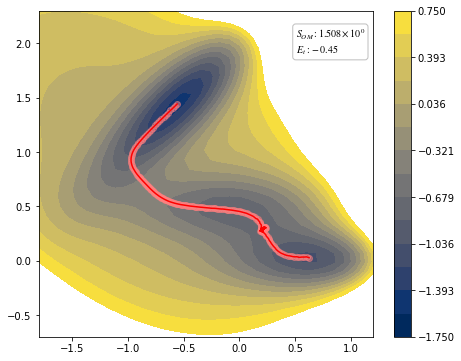

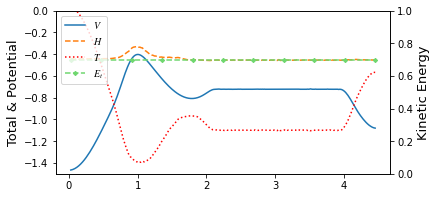

In [40]:
view(paths, viewer='MullerBrown')

In [ ]:
import numpy as np
from ase.pathway.paths import Paths
from ase.pathway.model import MullerBrown
from ase.pathway.projector import Mask
from ase.pathway.pathfinder import ADMD
from ase.pathway.gaussian import Gaussian, GaussianSearch
from ase.pathway.plotter import MullerBrownPlotter
P = 300

x = np.linspace(-0.55822365, 0.6234994, P)
y = np.linspace(1.44172582, 0.02803776, P)
p = np.array([[x], [y]])

hyperparameters = {'sigma_f': 1, 'sigma_n^f': 1e-8, 'sigma_n^e':1e-6,
                   'l^2': 0.1}
hyperparameters_bounds = {'sigma_f': (1, 1), 'sigma_n^f': (1e-8, 1e-6), 'sigma_n^e':(1e-6, 1e-4), 'l^2': (1e-4, 4)}
#Et='average'
#Et=-108.16672412
Et=-46.69951721 / 100
muE=1e-2
#label='/group1/schinavro/ThesisWork/Image2/auto_svg/data'
label='/group/schinavro/MullerBrown/test1/mb'
#dt = 1 / P 
dt = 0.01
Et_opt_tol = 0.05
#dt = 0.002
maxiter=3000
gam= 0.3
#action_name=['classic', 'Energy conservation']
#action_name=['Onsager Machulup']
action_name=['Onsager Machulup', 'Energy conservation']

model = MullerBrown()
#model = Gaussian(real_model=model, hyperparameters=hyperparameters, hyperparameters_bounds=hyperparameters_bounds, mean_type='zero')
finder = ADMD(action_name=action_name, Et=Et, muE=muE, Et_type='manual', maxiter=maxiter, gam=gam)
#finder = GaussianSearch(real_finder=finder, phases=['auto et'], Et_opt_tol=Et_opt_tol)
auto_paths = Paths('H', p,label=label, database=label,
              model=model,
              finder=finder, 
              prj=Mask(reference=np.array([0, 0, 0]), dt=dt),
              plotter=MullerBrownPlotter()
              )
#auto_paths.finder._pbs='fifi'



In [6]:
for i in range(4, 80, 5):
    print(i)

4
9
14
19
24
29
34
39
44
49
54
59
64
69
74
79


In [2]:
auto_paths.fluctuate(temperature=0.02)

In [3]:
auto_paths.search()

Action name  :  ['Onsager Machulup', 'Energy conservation']
Target energy:  -0.4669951721
Target type  :  manual
muE          :  0.01
         Current function value: 10731806.112699
         Iterations: 41
         Function evaluations: 133
         Gradient evaluations: 121
Desired error not necessarily achieved due to precision loss.
         Current function value: 3.054333
         Iterations: 872
         Function evaluations: 993
         Gradient evaluations: 981
Desired error not necessarily achieved due to precision loss.
         Current function value: 2.963323
         Iterations: 66
         Function evaluations: 118
         Gradient evaluations: 106
Desired error not necessarily achieved due to precision loss.
Optimization terminated successfully.
         Current function value: 2.962730
         Iterations: 1
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.

Gradient Error above tolerence! 
Emergency mode; Run wit

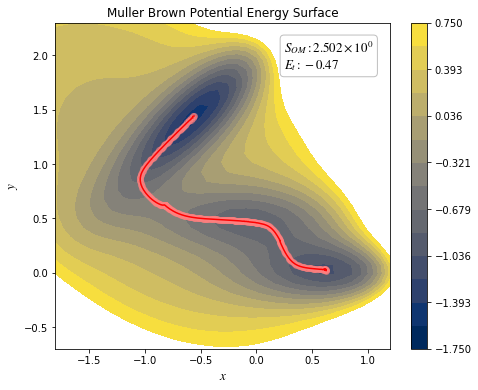

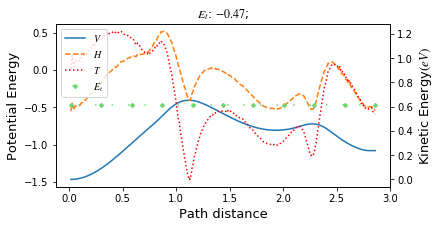

In [4]:
auto_paths.plot()

In [76]:
#_ = auto_paths.add_data(index=[0, -1])

In [2]:
#auto_paths.use_grad=False
while True:
    auto_paths.finder.search(auto_paths)
    if auto_paths.finder._res['nit'] < 3:
        break

Action name  :  ['Onsager Machulup', 'Energy conservation']
Target energy:  -0.4669951721
Target type  :  manual
muE          :  0.01
         Current function value: 2.969543
         Iterations: 399
         Function evaluations: 523
         Gradient evaluations: 511
Desired error not necessarily achieved due to precision loss.
Action name  :  ['Onsager Machulup', 'Energy conservation']
Target energy:  -0.4669951721
Target type  :  manual
muE          :  0.01
         Current function value: 2.966797
         Iterations: 11
         Function evaluations: 93
         Gradient evaluations: 81
Desired error not necessarily achieved due to precision loss.
Action name  :  ['Onsager Machulup', 'Energy conservation']
Target energy:  -0.4669951721
Target type  :  manual
muE          :  0.01
Optimization terminated successfully.
         Current function value: 2.966677
         Iterations: 1
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successful

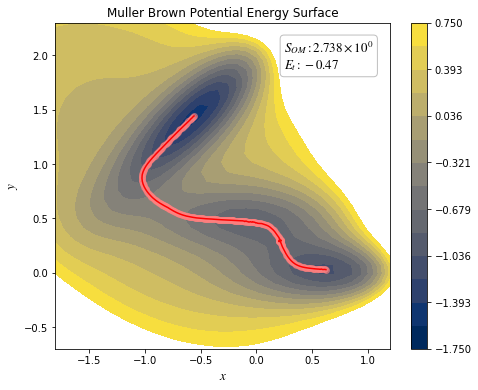

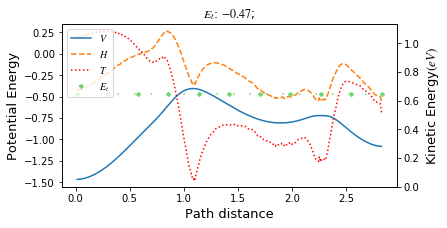

In [3]:
auto_paths.plot()

In [27]:
auto_paths.finder.use_grad=True
auto_paths.finder.check_grad(auto_paths, epsilon=1e-8)

10264147487.063562


In [12]:
auto_paths.model.check_grad(auto_paths, epsilon=1e-8)

3.092468348168216e-05


In [33]:
auto_paths.real_finder.use_grad=False
auto_paths.real_finder.search(auto_paths)

AttributeError: Key called `real_finder` not exist

In [4]:
auto_paths.get_velocity().shape

(2, 1, 299)